## FDMS TME3  

Kaggle [How Much Did It Rain? II](https://www.kaggle.com/c/how-much-did-it-rain-ii)

Florian Toque & Paul Willot  

# Data Vize

In [1]:
# from __future__ import exam_success
from __future__ import absolute_import
from __future__ import print_function

%matplotlib inline
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
import scipy.stats as stats

# Sk cheats
from sklearn.cross_validation import cross_val_score  # cross val
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import Imputer   # get rid of nan

* 13.765.202 lines in train.csv  
*  8.022.757 lines in test.csv  

### Load the dataset

In [44]:
%%time
filename = "data/reduced_train_100000.csv"
#filename = "data/reduced_test_100000.csv"
raw = pd.read_csv(filename)
raw = raw.set_index('Id')

CPU times: user 307 ms, sys: 49.4 ms, total: 356 ms
Wall time: 359 ms


In [45]:
raw['Expected'].describe()

count    100000.000000
mean        129.579825
std         687.622542
min           0.010000
25%           0.254000
50%           1.016000
75%           3.556002
max       32740.617000
Name: Expected, dtype: float64

Per wikipedia, a **value of more than 421 mm/h is considered "Extreme/large hail"**  
If we encounter the value 327.40 meter per hour, we should probably start building Noah's ark  
Therefor, it seems reasonable to **drop values too large**, considered as outliers

In [46]:
# Considering that the gauge may concentrate the rainfall, we set the cap to 1000
# Comment this line to analyse the complete dataset 
l = len(raw)
raw = raw[raw['Expected'] < 1000]
print("Dropped %d (%0.2f%%)"%(l-len(raw),(l-len(raw))/float(l)*100))

Dropped 4175 (4.17%)


In [12]:
raw.head(5)

,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
Id,,,,,,,,,,,,,,,,,,,,,
1,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,16,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,25,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,35,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,45,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254


### Quick analysis for the sparsity by column

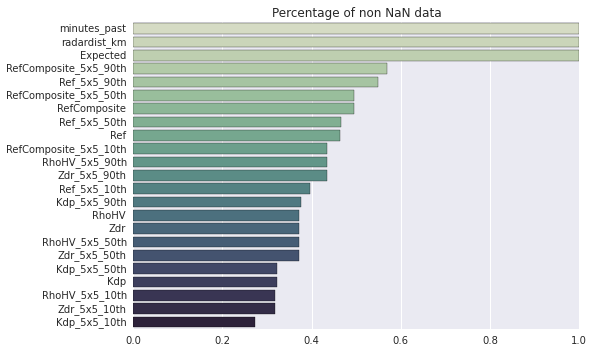

In [13]:
l = float(len(raw["minutes_past"]))
comp = [[1-raw[i].isnull().sum()/l , i] for i in raw.columns]
comp.sort(key=lambda x: x[0], reverse=True)

sns.barplot(zip(*comp)[0],zip(*comp)[1],palette=sns.cubehelix_palette(len(comp), start=.5, rot=-.75))
plt.title("Percentage of non NaN data")
plt.show()

We see that except for the fixed features **minutes_past, radardist_km and Expected** the dataset is mainly sparse.  
Let's transform the dataset to conduct more analysis

We regroup the data by ID

In [62]:
# We select all features except for the minutes past,
# because we ignore the time repartition of the sequence for now

features_columns = list([u'Ref', u'Ref_5x5_10th',
       u'Ref_5x5_50th', u'Ref_5x5_90th', u'RefComposite',
       u'RefComposite_5x5_10th', u'RefComposite_5x5_50th',
       u'RefComposite_5x5_90th', u'RhoHV', u'RhoHV_5x5_10th',
       u'RhoHV_5x5_50th', u'RhoHV_5x5_90th', u'Zdr', u'Zdr_5x5_10th',
       u'Zdr_5x5_50th', u'Zdr_5x5_90th', u'Kdp', u'Kdp_5x5_10th',
       u'Kdp_5x5_50th', u'Kdp_5x5_90th'])

def getXy(raw):
    selected_columns = list([ u'radardist_km', u'Ref', u'Ref_5x5_10th',
       u'Ref_5x5_50th', u'Ref_5x5_90th', u'RefComposite',
       u'RefComposite_5x5_10th', u'RefComposite_5x5_50th',
       u'RefComposite_5x5_90th', u'RhoHV', u'RhoHV_5x5_10th',
       u'RhoHV_5x5_50th', u'RhoHV_5x5_90th', u'Zdr', u'Zdr_5x5_10th',
       u'Zdr_5x5_50th', u'Zdr_5x5_90th', u'Kdp', u'Kdp_5x5_10th',
       u'Kdp_5x5_50th', u'Kdp_5x5_90th'])
    
    data = raw[selected_columns]
    
    docX, docY = [], []
    for i in data.index.unique():
        if isinstance(data.loc[i],pd.core.series.Series):
            m = [data.loc[i].as_matrix()]
            docX.append(m)
            docY.append(float(raw.loc[i]["Expected"]))
        else:
            m = data.loc[i].as_matrix()
            docX.append(m)
            docY.append(float(raw.loc[i][:1]["Expected"]))
    X , y = np.array(docX) , np.array(docY)
    return X,y

In [63]:
raw.index.unique()

array([   1,    2,    3, ..., 9539, 9540, 9541])

_How much observations is there for each ID ?_

Average gauge observation in mm: 17.55


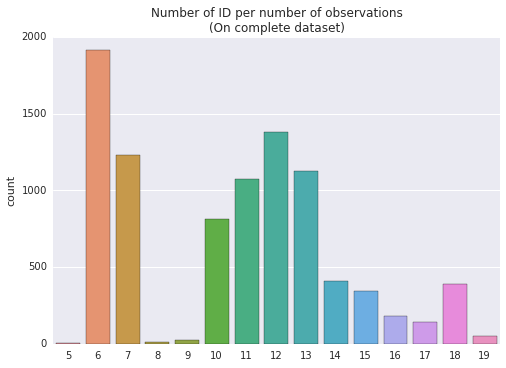

In [48]:
X,y=getXy(raw)

tmp = []
for i in X:
    tmp.append(len(i))
tmp = np.array(tmp)
sns.countplot(tmp,order=range(tmp.min(),tmp.max()+1))
plt.title("Number of ID per number of observations\n(On complete dataset)")
plt.plot()

print("Average gauge observation in mm: %0.2f"%y.mean())

We see there is a lot of ID with 6 or 12 observations, that mean one every 5 or 10 minutes on average.  

In [50]:
pd.DataFrame(y).describe()

,0
count,9100.000000
mean,17.547618
std,82.682028
min,0.010000
25%,0.254000
50%,0.762000
75%,2.794001
max,876.300500



Now let's do the analysis on different subsets:

### On fully filled dataset

In [51]:
noAnyNan = raw.loc[raw[features_columns].dropna(how='any').index.unique()]

Average gauge observation in mm: 17.55


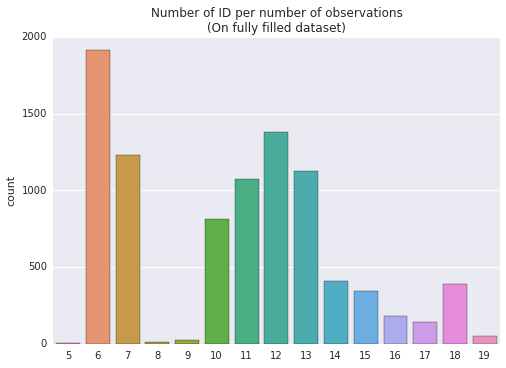

In [52]:
X,y=getXy(raw)

tmp = []
for i in X:
    tmp.append(len(i))
tmp = np.array(tmp)
sns.countplot(tmp,order=range(tmp.min(),tmp.max()+1))
plt.title("Number of ID per number of observations\n(On fully filled dataset)")
plt.plot()

print("Average gauge observation in mm: %0.2f"%y.mean())

In [53]:
pd.DataFrame(y).describe()

,0
count,9100.000000
mean,17.547618
std,82.682028
min,0.010000
25%,0.254000
50%,0.762000
75%,2.794001
max,876.300500


In [54]:
noFullNan = raw.loc[raw[features_columns].dropna(how='all').index.unique()]

In [56]:
index[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Average gauge observation in mm: 17.55


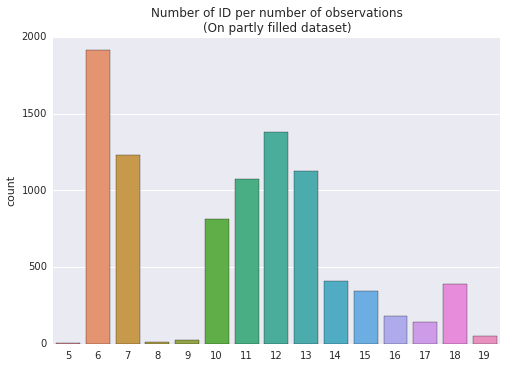

In [57]:
X,y=getXy(raw)

tmp = []
for i in X:
    tmp.append(len(i))
tmp = np.array(tmp)
sns.countplot(tmp,order=range(tmp.min(),tmp.max()+1))
plt.title("Number of ID per number of observations\n(On partly filled dataset)")
plt.plot()

print("Average gauge observation in mm: %0.2f"%y.mean())

In [58]:
pd.DataFrame(y).describe()

,0
count,9100.000000
mean,17.547618
std,82.682028
min,0.010000
25%,0.254000
50%,0.762000
75%,2.794001
max,876.300500


In [23]:
fullNan = raw.drop(raw[features_columns].dropna(how='all').index)

Average gauge observation in mm: 85.76


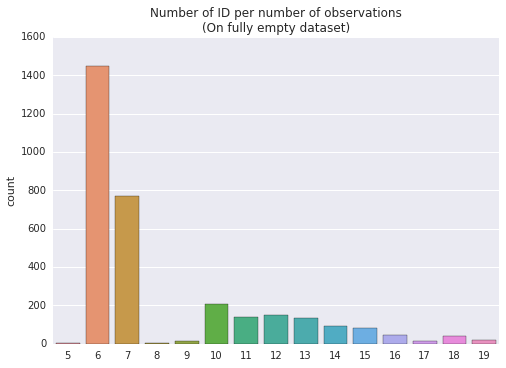

In [24]:
X,y=getXy(fullNan)

tmp = []
for i in X:
    tmp.append(len(i))
tmp = np.array(tmp)
sns.countplot(tmp,order=range(tmp.min(),tmp.max()+1))
plt.title("Number of ID per number of observations\n(On fully empty dataset)")
plt.plot()

print("Average gauge observation in mm: %0.2f"%y.mean())

In [25]:
pd.DataFrame(y).describe()

,0
count,3171.000000
mean,85.763871
std,283.845704
min,0.010000
25%,0.254000
50%,0.508000
75%,1.425001
max,1984.503000


**Strangely we notice that the less observations there is, the more it rains on average**  
**However more of the expected rainfall fall below 0.5**  
_What prediction should we make if there is no data?_

In [15]:
print("%d observations" %(len(raw)))
#print("%d fully filled, %d partly filled, %d fully empty"
#      %(len(noAnyNan),len(noFullNan),len(raw)-len(noFullNan)))
print("%0.1f%% fully filled, %0.1f%% partly filled, %0.1f%% fully empty"
      %(len(noAnyNan)/float(len(raw))*100,
        len(noFullNan)/float(len(raw))*100,
        (len(raw)-len(noFullNan))/float(len(raw))*100))

100000 observations
37.5% fully filled, 71.5% partly filled, 28.5% fully empty


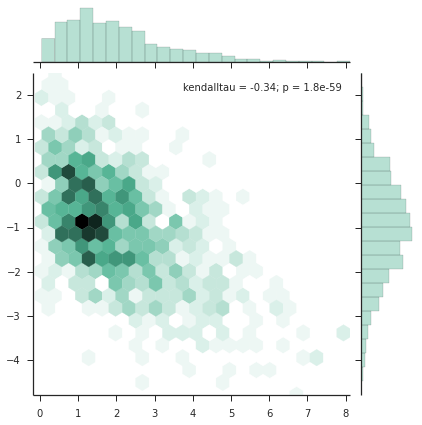

In [61]:
import numpy as np
from scipy.stats import kendalltau
import seaborn as sns
#sns.set(style="ticks")

rs = np.random.RandomState(11)
x = rs.gamma(2, size=1000)
y = -.5 * x + rs.normal(size=1000)

sns.jointplot(x, y, kind="hex", stat_func=kendalltau, color="#4CB391")